# Spectroscopic Fitting for in-vivo Metabolomics

## AKA *Accurately inferring body chemistry using an MRI machine*

# Example single voxel spectra

![Brain spectra Example](https://www.dovepress.com/cr_data/article_fulltext/s56000/56404/img/fig1.jpg)

# Some problems in-vivo:

## Non-ideal measurement

* SNR is often poor; accurate measurement requires averaging
* People move and breathe
* Suceptibility of tissue causes local magnetic field changes and ruins homogenaity

#### The following artifacts occur

* Line broadening
    * "structureless" broadening via local inhomogenaity
    * motion broadening frequency modulation
* Frequency shift: Peaks move up to several times the line width in spectroscopy of breast tissue!
* Incomplete water/fat suppression:

## Slow fitting

* Existing quantification state of the art is based on iterative nonlinear fitting
* Slow!
* Doesn't attack artifacts with a model

# Existing work

Not a lot of work seems to have been done yet.

### Magnetic Resonance Spectroscopy Quantification using Deep Learning
* by Nima Hatami, Michael Sdika, and Helene Ratiney
* https://arxiv.org/pdf/1806.07237.pdf
* A relatively simple paper providing a bit of a baseline. Has a useful (introductory) generative signal model. A bit light on analysis.

### Quantification of Metabolites in Magnetic Resonance Spectroscopic Imaging Using Machine Learning
* Dhritiman Das, Eduardo Coello, Rolf F. Schulte and Bjoern H. Menze
* http://sci-hub.tw/10.1007/978-3-319-66179-7_53
* Precursor work using random forests

# Ideas

* Use the simple forward signal model to generate loads of training data.
* 1D spectra are not large!  1024 data points in 1D is standard, cf 32x32 2-color image

## Spectral Domain

* Dip our toes in the water by reproducing the Hatami paper
* Regression: Compute metabolite concentraions and linewidths from spectrum
* Perhaps try a residual network?

## Time Domain

* Train model to reconstruct a clean spectrum from corrupted time domian data
* Try to attack in vivo artifacts directly using a model.
* Try to train a model to suppress water artifact
* Artifacts: Incomplete water suppression, frequency shift, line broadening

# Sample data

ISMRM MRS fitting challenge gives clean example spectra for 20 metabolites or so:

https://www.ismrm.org/workshops/Spectroscopy16/mrs_fitting_challenge/

# Load ISMRM source data

Run the script in `spectro_data/get_data.jl` to download and unzip the source data.

In [45]:
using DelimitedFiles
using Plots, Measures
using FFTW

In [46]:
"""
    read_ismrm_file(fname)

Read data from `fname` in the text format given for the ISMRM fitting challenge
"""
function read_ismrm_file(fname)
    # Need to explicitly construct a dense Vector, as FFTW can't work with generic AbstractArray?? :-(
    Vector(reinterpret(ComplexF64, vec(transpose(readdlm(fname)))))
end

read_ismrm_file

# Define spectral metadata for spectral axes

Constants from https://www.ismrm.org/workshops/Spectroscopy16/mrs_fitting_challenge/

In [48]:
freq      = 123.2e6 # Hz
bandwidth = 4000    # Hz
numsamp   = 2048
df = bandwidth / numsamp

f = (-numsamp÷2:numsamp÷2-1) / numsamp * bandwidth

f_ppm = f./freq.*1e6

-16.233766233766232:0.015853287337662336:16.21791294642857

# Plot reference basis set

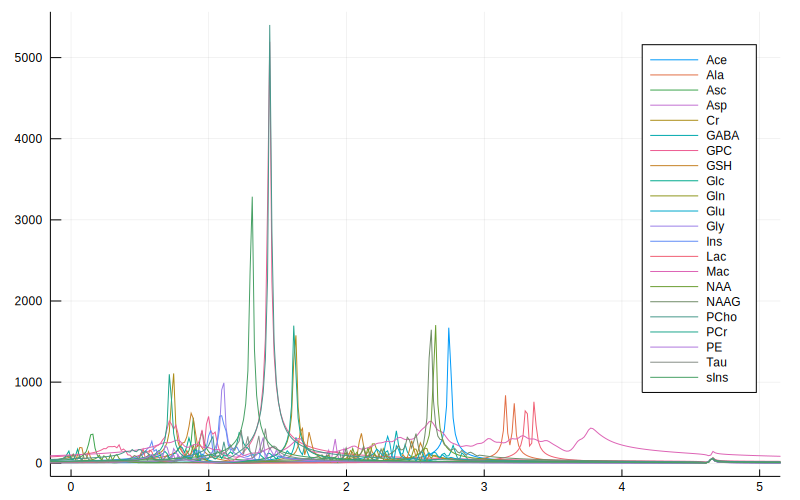

In [51]:
p = plot(size=(800,500), xlim=[0,5])
source_dir = "spectro_data/basisset_text"
for file in readdir(source_dir)
    fid = read_ismrm_file(joinpath(source_dir, file))
    spec = fftshift(fft(fid))
    plot!(p, f_ppm, abs.(spec), label=file[1:end-4])
end
p

# Signal Model

Each time series is a sum of decaying complex sinusoids